In [1]:
!pip install pennylane-lightning-gpu
!pip install pennylane pennylane-lightning-gpu custatevec-cu12 --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 4.0 MB/s eta 0:00:00


In [2]:
!pip install jax
!pip install scikit-learn
!pip install pennylane

In [6]:
import sklearn.datasets
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from collections import defaultdict

results = defaultdict(list)
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

results["quantum"] = defaultdict(list)
results["classical"] = defaultdict(list)

for no_of_classes in [2,5]:
    for p in [2,4,6]:
        X = sklearn.datasets.load_digits(n_class=no_of_classes)

        scaler = StandardScaler().fit(X.data)
        X_scaled = scaler.transform(X.data)

        pca = PCA(n_components=p)
        pca.fit(X_scaled)
        X_transform_pca = pca.transform(X_scaled)

        y_scaled = 2 * (X.target - 0.5)

        X_train, X_test, y_train, y_test = train_test_split(X_transform_pca, y_scaled)

        for x in range(len(X_train)):
            X_train[x] = X_train[x]/np.linalg.norm(X_train[x])

        for x in range(len(X_test)):
            X_test[x] = X_test[x]/np.linalg.norm(X_test[x])

        n_qubits = len(X_train[0])

        print('Number of qubits being used : ', n_qubits)

        dev_kernel = qml.device("default.qubit.jax", wires=n_qubits)

        projector = np.zeros((2**n_qubits, 2**n_qubits))
        projector[0, 0] = 1

        @jax.jit
        @qml.qnode(dev_kernel, interface="jax")
        def kernel(x):
            AngleEmbedding(x[0], wires=range(n_qubits))
            qml.adjoint(AngleEmbedding)(x[1], wires=range(n_qubits))
            return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

        jit_circuit = jax.jit(kernel)

        def kernel_matrix(A, B):
            return np.array([[jit_circuit(jnp.array([a, b])) for b in B] for a in A])

        qclassifier = SVC(kernel=kernel_matrix).fit(X_train, y_train)

        predictions = qclassifier.predict(X_test)
        score = accuracy_score(predictions, y_test)

        results['quantum'][no_of_classes].append((p,score))
        print (no_of_classes, p, score)

        clf = SVC(kernel='rbf')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        results['classical'][no_of_classes].append((p,accuracy_score(predictions, y_test)))

print (results)

Number of qubits being used :  2
2 2 0.9888888888888889
Number of qubits being used :  4
2 4 1.0
Number of qubits being used :  6
2 6 0.9888888888888889
Number of qubits being used :  2
5 2 0.8230088495575221
Number of qubits being used :  4
5 4 0.9424778761061947
Number of qubits being used :  6
5 6 0.9513274336283186
defaultdict(<class 'list'>, {'quantum': defaultdict(<class 'list'>, {2: [(2, 0.9888888888888889), (4, 1.0), (6, 0.9888888888888889)], 5: [(2, 0.8230088495575221), (4, 0.9424778761061947), (6, 0.9513274336283186)]}), 'classical': defaultdict(<class 'list'>, {2: [(2, 1.0), (4, 1.0), (6, 1.0)], 5: [(2, 0.8185840707964602), (4, 0.9424778761061947), (6, 0.9734513274336283)]})})


No of dimensions used for 10 classes -  2


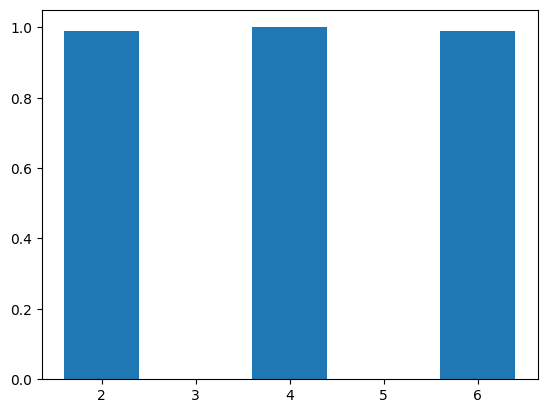

No of dimensions used for 10 classes -  5


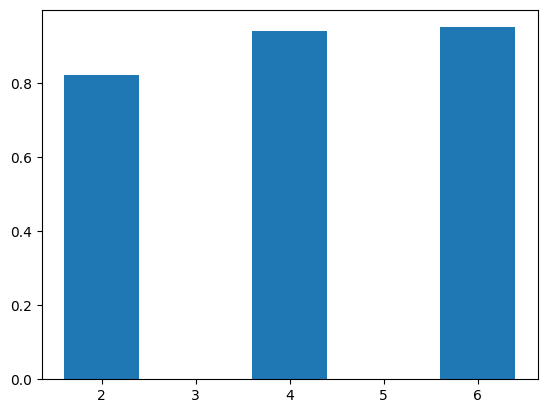

No of dimensions used for 10 classes -  2


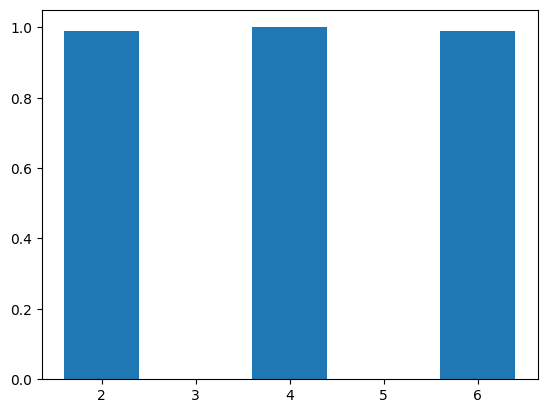

No of dimensions used for 10 classes -  5


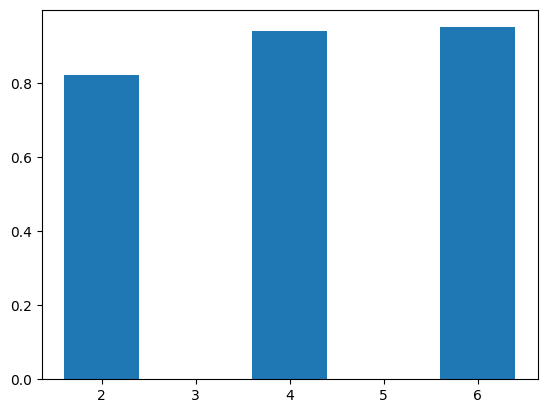

In [7]:
for i in results['quantum'].keys():
        print ('No of dimensions used for 10 classes - ', i)
        qubits, accuracies = list(zip(*results['quantum'][i]))

        plt.bar(qubits, accuracies)
        plt.show()

for i in results['classical'].keys():
        print ('No of dimensions used for 10 classes - ', i)
        qubits, accuracies = list(zip(*results['quantum'][i]))

        plt.bar(qubits, accuracies)
        plt.show()


In [25]:
for i in results['quantum'].keys():
  print('\nNo of features ( before PCA ) : ', i)
  print ('PCA\t Quantum\t\t Classical')
  for j in range(len(results['quantum'][i])):
    pca, accuracy = results['quantum'][i][j]
    print(pca,'\t', accuracy, '\t',results['classical'][i][j][1])


No of features ( before PCA ) :  2
PCA	 Quantum		 Classical
2 	 0.9888888888888889 	 1.0
4 	 1.0 	 1.0
6 	 0.9888888888888889 	 1.0

No of features ( before PCA ) :  5
PCA	 Quantum		 Classical
2 	 0.8230088495575221 	 0.8185840707964602
4 	 0.9424778761061947 	 0.9424778761061947
6 	 0.9513274336283186 	 0.9734513274336283
